### Metrics
1. Proportion of interventions processed
    - numfixation > 0 (-1: never triggered, 0: triggered but never looked at)
2.  How early participants look at each intervention
    - timetofirstfixation (since the beginning of the task) - how long it takes to trigger the intervention after the task has started
    - (-1: never looked at the triggered intervention | numfixation = 0)

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
# pd.options.display.max_rows = None

In [2]:
# indices
MSNV = [3, 5, 9, 11, 20, 27, 28, 30, 60, 66, 62, 72, 74] 
# missing file for 76

Sc_ids = [60, 63, 66, 68, 69, 71, 73, 75, 77, 78, 81, 24, 25, 29, 30, 34, 35, 37, 38, 39, 4, 41, 9, 42, 43, 44, 46,
          49, 5, 50, 51, 54, 56, 6, 10, 12, 13, 14, 15, 17, 18, 2, 20, 21, 22, 85]


In [3]:
# loading all 13 interventions features files
datasets = {}

for msnv in MSNV:
    # load the file
    df = pd.read_csv("AOI data/" + str(msnv) + "_intervention_features.tsv", sep='\t')
    
    # restructuring
    
    sc_ids = []
    for item in df['Sc_id']:
        if 'msnv' in item:
            sc_id = item
        
        sc_ids.append(sc_id)

    df.insert(loc=0, column='sc_id', value=sc_ids)
    df.insert(loc=1, column='msnv_id', value=df['Sc_id'])

    
    # columns of interest
    nf_cols = [col for col in df.columns if 'numfixations' in col]
    ttff_cols = [col for col in df.columns if 'timetofirstfixation' in col]

    # keep only the relevant row for each participant
    df = df[df['msnv_id'] == str(msnv)]
    
    # keep only the columns of interest 
    df = df.loc[:, (['sc_id', 'msnv_id'] + nf_cols + ttff_cols)]
    
    datasets[msnv] = df

### How early participants look at each intervention (timetofirstfixation)

- timetofirstfixation: how long until user looks at the intervention (from the start of the task)
- trigger_delay: how long until intervention is triggered (from the start of the task)
- how early participants look at each intervention: timetofirstfixation - trigger_delay

In [4]:
# loading segment data
segs = {}
trigger_segs = {}

# integration of the two
segments = {} 
all_segs = pd.DataFrame([])

for Sc_id in Sc_ids:
    segs[Sc_id] = pd.read_csv("segs/msnv" + str(Sc_id) + ".seg", sep='\t', 
                              names=['scene', 'seg', 'seg_start_stamp', 'seg_end_stamp'])
    
    trigger_segs[Sc_id] = pd.read_csv("trigger_segs/msnv" + str(Sc_id) + "_trigger.seg", sep='\t',
                                     names=['scene', 'seg', 'trigger_start_stamp', 'seg_end_stamp'])
    
    merged = pd.merge(trigger_segs[Sc_id], segs[Sc_id], on='seg_end_stamp')
    merged = merged[['seg_y', 'seg_x', 'seg_start_stamp', 'trigger_start_stamp', 'seg_end_stamp']]
    merged = merged.rename(columns={'seg_y': 'msnv_id', 'seg_x': 'intervention'})
    merged['trigger_delay'] = merged['trigger_start_stamp'] - merged['seg_start_stamp']
    merged.insert(loc=0, column='sc_id', value=Sc_id)
    segments[Sc_id] = merged
    
    all_segs = all_segs.append(merged)

all_segs.reset_index(drop=True, inplace=True)

In [5]:
# adding the corresponding numfixations and timetofirstfixation for each AOI to all_segs 

nf = []
ttff = []

for sc_id, msnv_id, intervention in zip(all_segs['sc_id'], all_segs['msnv_id'], all_segs['intervention']):
    try:
        df = datasets[int(msnv_id)]
      
        nf.append(df[df['sc_id'] == ("msnv" + str(sc_id) + "_allsc")].iloc[0, :][str(intervention)+'_numfixations'])
        ttff.append(df[df['sc_id'] == ("msnv" + str(sc_id) + "_allsc")].iloc[0, :][str(intervention)+'_timetofirstfixation'])
    except:
        nf.append(np.NaN)
        ttff.append(np.NaN)
        
all_segs['numfixations'] = nf
all_segs['timetofirstfixation'] = ttff

# compute trigger_to_fixation_time (except for those with timetofirstfixation == -1)

all_segs['trigger_to_fixation_time'] = all_segs['timetofirstfixation'].replace(-1, np.NaN) - all_segs['trigger_delay']

# sort and save the file
all_segs = all_segs.sort_values(by=['sc_id','msnv_id','intervention']).reset_index(drop=True)
all_segs.to_csv("Results\\integrated_data.csv", index=True)

all_segs_oredered_time = all_segs.sort_values(by=['sc_id','trigger_start_stamp']).reset_index(drop=True)
all_segs_oredered_time.to_csv("Results\\all_segs_oredered_time.csv", index=True)
all_segs = all_segs_oredered_time

# display(all_segs)

### trigger_to_fixation_time

In [6]:
trigger_to_fixation_times = all_segs[['sc_id', 'msnv_id', 'intervention', 'trigger_to_fixation_time']].groupby(
    ['sc_id', 'msnv_id'], sort=False).apply(lambda x: pd.Series( # remove sort = false for ordered based on type
    {'mean trigger_to_fixation_time': (x['trigger_to_fixation_time'].mean()),
     'std trigger_to_fixation_time' : (x['trigger_to_fixation_time'].std()),
     'count'                        : (x['trigger_to_fixation_time'].count())}))

trigger_to_fixation_times.to_csv("Results\\trigger_to_fixation_times.csv", index=True)

trigger_to_fixation_times_participant = trigger_to_fixation_times.groupby(
    ['sc_id']).apply(lambda x: pd.Series(
    {'mean trigger_to_fixation_time': (x['mean trigger_to_fixation_time'].mean()),
     'std trigger_to_fixation_time' : (x['mean trigger_to_fixation_time'].std())}))

trigger_to_fixation_times_participant.to_csv("Results\\trigger_to_fixation_times_participant.csv", index=True)

# display(trigger_to_fixation_times)
# display(trigger_to_fixation_times_participant)
# trigger_to_fixation_times

### proportions of numfixations 

In [7]:
# remove 76 as it has missing data
all_segs.drop(all_segs[all_segs['msnv_id'] == 76].index, inplace=True)

groupby_sc_id_msnv = all_segs[['sc_id', 'msnv_id', 'numfixations']].groupby(['sc_id', 'msnv_id'])

proportion_counts = groupby_sc_id_msnv.apply(
    lambda x: pd.Series({'num_processed': (np.sum(x['numfixations'] > 0 )), 
                         'num_triggered': (np.sum(x['numfixations'] >= 0)),
                         'total': len([col for col in datasets[x['msnv_id'].values[0]].columns 
                                       if '_rule_numfixations' in col])}))

proportion_counts['processed/triggered'] = proportion_counts['num_processed'] / proportion_counts['num_triggered']
proportion_counts['triggered/total']     = proportion_counts['num_triggered'] / proportion_counts['total']
proportion_counts['processed/total']     = proportion_counts['num_processed'] / proportion_counts['total']




proportion_stats = proportion_counts.groupby(['sc_id']).apply(
    lambda x: pd.Series({'mean processed/triggered': (x['processed/triggered']).mean(),
                         'std processed/triggered' : (x['processed/triggered']).std(),
                         'mean processed/total': (x['processed/total']).mean(),
                         'std processed/total' : (x['processed/total']).std(),
                         'mean triggered/total'    : (x['triggered/total']).mean(),
                         'std triggered/total' : (x['triggered/total']).std()}))

# save files
proportion_counts.to_csv("Results\\proportion_counts.csv", index=True)
proportion_stats.to_csv("Results\\proportion_stats.csv", index=True)

# display(proportion_stats)
# display(proportion_counts)

In [8]:
#### Extra

In [9]:
df = all_segs.sort_values(by=['sc_id','msnv_id','trigger_start_stamp']).reset_index(drop=True)
df.insert(loc=5, column='fade_stamp', value=0)

firstfixation_stamp = []
for sss, ttff in zip(df['seg_start_stamp'], df['timetofirstfixation']):
    if ttff != -1:
        firstfixation_stamp.append(sss + ttff)
    else:
        firstfixation_stamp.append(-1)
        
df.insert(loc=7, column='firstfixation_stamp', value=firstfixation_stamp)

fade_stamp = []
for index in df.index:
    if index +1 <= df.index.max():
        if df.loc[index, 'msnv_id'] == df.loc[index +1, 'msnv_id']:
            fade_stamp.append(df.loc[index +1, 'trigger_start_stamp'])
        else:
            fade_stamp.append(df.loc[index, 'seg_end_stamp'])
    else:
            fade_stamp.append(df.loc[index, 'seg_end_stamp'])
            
df['fade_stamp'] = fade_stamp

processed_immediately = []

for trigger_start_stamp, fade_stamp, firstfixation_stamp in zip(
    df['trigger_start_stamp'], df['fade_stamp'], df['firstfixation_stamp']):
    
    if trigger_start_stamp < firstfixation_stamp and firstfixation_stamp < fade_stamp:
        processed_immediately.append(1)
    else:
        processed_immediately.append(0)

df['imm_processed'] = processed_immediately
df.to_csv("Results\\integrated_data_active.csv", index=True)

In [10]:
df[df['imm_processed']==1]
df.head(10)

,sc_id,msnv_id,intervention,seg_start_stamp,trigger_start_stamp,fade_stamp,seg_end_stamp,firstfixation_stamp,trigger_delay,numfixations,timetofirstfixation,trigger_to_fixation_time,imm_processed
0,2,3,3_ref_106_rule,682955,689819.0,700002.0,743171,723534.0,6864.0,7.0,40579.0,33715.0,0
1,2,3,3_ref_101_rule,682955,700002.0,704499.0,743171,732361.0,17047.0,2.0,49406.0,32359.0,0
2,2,3,3_ref_100_rule,682955,704499.0,710869.0,743171,-1.0,21544.0,0.0,-1.0,NaN,0
3,2,3,3_ref_105_rule,682955,710869.0,716506.0,743171,729072.0,27914.0,3.0,46117.0,18203.0,0
4,2,3,3_ref_102_rule,682955,716506.0,743171.0,743171,-1.0,33551.0,0.0,-1.0,NaN,0
5,2,5,5_ref_100_rule,549675,568299.0,578191.0,643899,608617.0,18624.0,10.0,58942.0,40318.0,0
6,2,5,5_ref_101_rule,549675,578191.0,582712.0,643899,608475.0,28516.0,4.0,58800.0,30284.0,0
7,2,5,5_ref_103_rule,549675,582712.0,589723.0,643899,625430.0,33037.0,18.0,75755.0,42718.0,0
8,2,5,5_ref_104_rule,549675,589723.0,643899.0,643899,631717.0,40048.0,1.0,82042.0,41994.0,1
9,2,9,9_ref_101_rule,904609,914665.0,922750.0,959986,933180.0,10056.0,11.0,28571.0,18515.0,0


In [34]:
imm_processed_proportion_counts = df.groupby(['sc_id','msnv_id']).apply(
    lambda x: pd.Series({'num_imm_processed': (np.sum(x['imm_processed'] == 1)), 
                         'num_triggered': (np.sum(x['numfixations'] >= 0))}))

imm_processed_proportion_counts['imm_processed/triggered'] = (imm_processed_proportion_counts['num_imm_processed'] /
                                                              imm_processed_proportion_counts['num_triggered'])
imm_proportion_stats = imm_processed_proportion_counts.groupby(['sc_id']).apply(
    lambda x: pd.Series({'mean imm_processed/triggered': (x['imm_processed/triggered']).mean(),
                         'std imm_processed/triggered' : (x['imm_processed/triggered']).std()}))

# display(imm_processed_proportion_counts.head(50))
mean = imm_proportion_stats['mean imm_processed/triggered'].mean()
std = imm_proportion_stats['mean imm_processed/triggered'].std()

print('mean:', mean)
print('std:', std)

imm_processed_proportion_counts.to_csv("Results\\All_proportion_counts.csv", index=True)

mean: 0.590515171221693
std: 0.15700771771418193


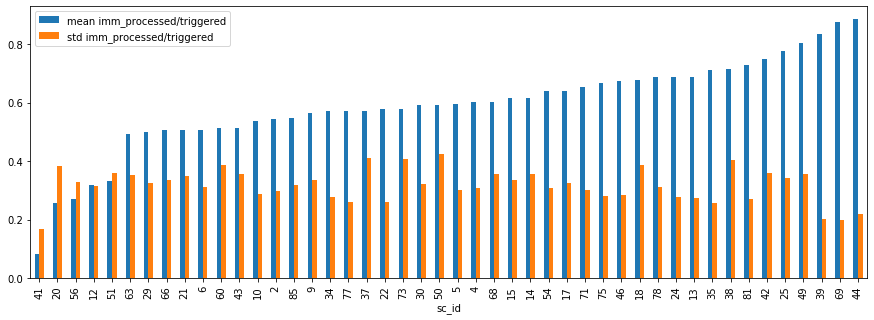

In [12]:
bar_df = imm_proportion_stats
imm = bar_df[['mean imm_processed/triggered', 'std imm_processed/triggered']].sort_values(by='mean imm_processed/triggered')
imm.plot.bar(figsize=(15,5));

mean: 0.8514501199283807
std: 0.1980626707223866


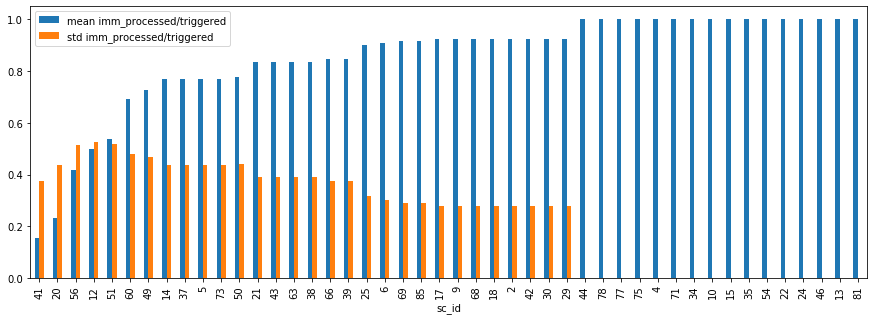

In [13]:
last_interventions = df[df['fade_stamp'] == df['seg_end_stamp']]

last_proportion_counts = last_interventions.groupby(['sc_id','msnv_id']).apply(
    lambda x: pd.Series({'num_imm_processed': (np.sum(x['imm_processed'] == 1)), 
                         'num_triggered': (np.sum(x['numfixations'] >= 0))}))

last_proportion_counts['imm_processed/triggered'] = (last_proportion_counts['num_imm_processed'] /
                                                     last_proportion_counts['num_triggered'])

last_proportion_stats = last_proportion_counts.groupby(['sc_id']).apply(
    lambda x: pd.Series({'mean imm_processed/triggered': (x['imm_processed/triggered']).mean(),
                         'std imm_processed/triggered' : (x['imm_processed/triggered']).std()}))


mean = last_proportion_stats['mean imm_processed/triggered'].mean()
std = last_proportion_stats['mean imm_processed/triggered'].std()

print('mean:', mean)
print('std:', std)

bar_df = last_proportion_stats
imm = bar_df[['mean imm_processed/triggered', 'std imm_processed/triggered']].sort_values(by='mean imm_processed/triggered')
imm.plot.bar(figsize=(15,5));

mean: 0.21230618817575336
std: 0.2239067643468856


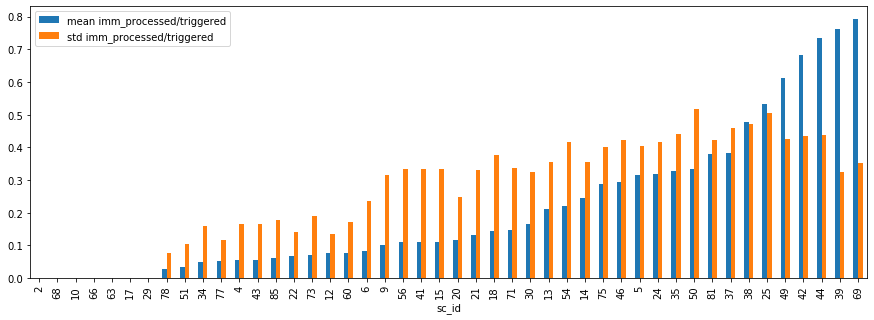

In [14]:
excluding_last_interventions = df[df['fade_stamp'] != df['seg_end_stamp']]

excluding_last_proportion_counts = excluding_last_interventions.groupby(['sc_id','msnv_id']).apply(
    lambda x: pd.Series({'num_imm_processed': (np.sum(x['imm_processed'] == 1)), 
                         'num_triggered': (np.sum(x['numfixations'] >= 0))}))

excluding_last_proportion_counts['imm_processed/triggered'] = (excluding_last_proportion_counts['num_imm_processed'] /
                                                               excluding_last_proportion_counts['num_triggered'])

excluding_last_proportion_stats = excluding_last_proportion_counts.groupby(['sc_id']).apply(
    lambda x: pd.Series({'mean imm_processed/triggered': (x['imm_processed/triggered']).mean(),
                         'std imm_processed/triggered' : (x['imm_processed/triggered']).std()}))


mean = excluding_last_proportion_stats['mean imm_processed/triggered'].mean()
std = excluding_last_proportion_stats['mean imm_processed/triggered'].std()

print('mean:', mean)
print('std:', std)

bar_df = excluding_last_proportion_stats
imm = bar_df[['mean imm_processed/triggered', 'std imm_processed/triggered']].sort_values(by='mean imm_processed/triggered')
imm.plot.bar(figsize=(15,5));

excluding_last_proportion_counts.to_csv("Results\\Excluding_last_interventions_proportion_counts.csv", index=True)
excluding_last_interventions.to_csv("Results\\All_data_excluding_last_interventions.csv", index=True)

In [15]:
ttf_per_msnv = all_segs[['sc_id', 'msnv_id', 'trigger_to_fixation_time']].groupby(['sc_id', 'msnv_id']).apply(lambda x: pd.Series(
    {'mean trigger_to_fixation_time': (x['trigger_to_fixation_time'].mean()),
     'std trigger_to_fixation_time' : (x['trigger_to_fixation_time'].std())
     }))

ttf_per_msnv = ttf_per_msnv[['mean trigger_to_fixation_time']].groupby(['msnv_id']).apply(lambda x: pd.Series(
    {'mean trigger_to_fixation_time': (x['mean trigger_to_fixation_time'].mean()),
     'std trigger_to_fixation_time' : (x['mean trigger_to_fixation_time'].std())
     }))


ttf_per_msnv
print(ttf_per_msnv['mean trigger_to_fixation_time'].mean())

16619.41639360364


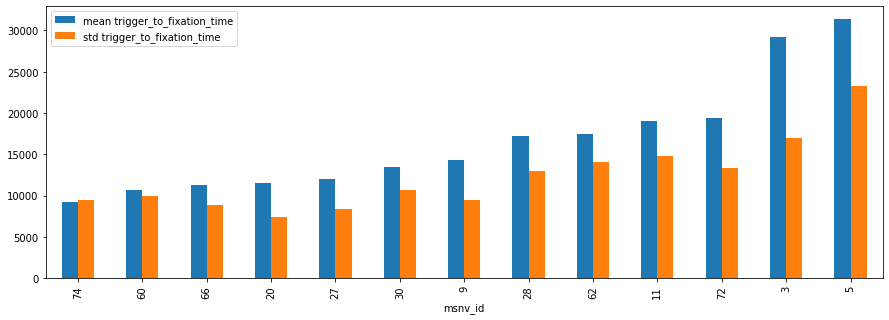

In [16]:
bar_df = ttf_per_msnv
ttf = ttf_per_msnv[['mean trigger_to_fixation_time', 'std trigger_to_fixation_time']].sort_values(by='mean trigger_to_fixation_time')
ttf.plot.bar(figsize=(15,5));

In [17]:
df = all_segs_oredered_time[['sc_id', 'msnv_id']].groupby(['sc_id', 'msnv_id']).count()
df.reset_index(level=1, inplace=True)
df = df.groupby(['sc_id']).count()
# df

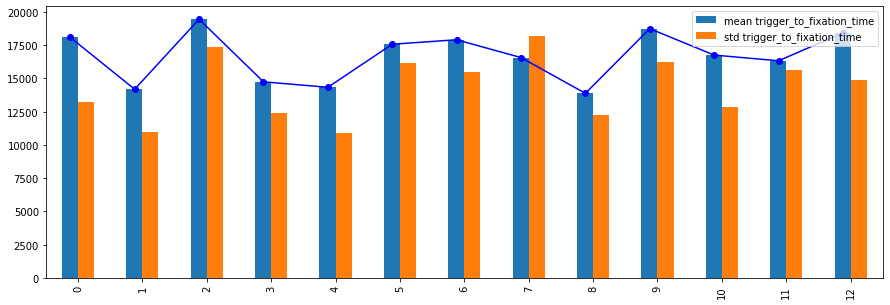

In [18]:
df = all_segs_oredered_time[['sc_id', 'msnv_id', 'trigger_to_fixation_time']].groupby(['sc_id','msnv_id'], sort=False).apply(
    lambda x: pd.Series(
    {'mean trigger_to_fixation_time': (x['trigger_to_fixation_time'].mean()),
     'std trigger_to_fixation_time' : (x['trigger_to_fixation_time'].std())
     }))

times = {}

for t in range(0, 13):
    times[t] = []
    for group in df.groupby(['sc_id']):
        try:
            times[t].append(list(group[1]['mean trigger_to_fixation_time'])[t])
        except:
            times[t].append(np.nan)
            
times_df = pd.DataFrame(times)

data = {'mean trigger_to_fixation_time': times_df.T.mean(axis=1), 
        'std trigger_to_fixation_time': times_df.T.std(axis=1)}
mean_times_df = pd.DataFrame(data)


bar_df = mean_times_df
ttf = mean_times_df[['mean trigger_to_fixation_time', 'std trigger_to_fixation_time']]#.sort_values(by='mean trigger_to_fixation_time')
ttf.plot.bar(figsize=(15,5));

plt.plot(bar_df.index-0.12, bar_df['mean trigger_to_fixation_time'], 'o-', color='blue');

In [19]:
from scipy.stats import f_oneway
# display(times_df)
df = times_df
Anova = f_oneway(df[0].dropna(), df[1].dropna(), df[2].dropna(), df[3].dropna(),
                 df[4].dropna(), df[5].dropna(), df[6].dropna(), df[7].dropna(),
                 df[8].dropna(), df[9].dropna(), df[10].dropna(), df[11].dropna(),
                 df[12].dropna())
Anova

F_onewayResult(statistic=0.7085217562375551, pvalue=0.7437614709575503)

In [20]:
ttf_per_msnv = all_segs[['sc_id', 'msnv_id', 'trigger_to_fixation_time']].groupby(['sc_id', 'msnv_id']).apply(lambda x: pd.Series(
    {'mean trigger_to_fixation_time': (x['trigger_to_fixation_time'].mean()),
     'std trigger_to_fixation_time' : (x['trigger_to_fixation_time'].std())
     }))

docs = {}
for msnv in ttf_per_msnv.groupby(['msnv_id']):
    docs[msnv[0]] = pd.DataFrame(list(msnv[1]['mean trigger_to_fixation_time']), columns=[msnv[0]])
    #print(msnv[1]['mean trigger_to_fixation_time'])

Anova = f_oneway(docs[MSNV[0]].dropna(), docs[MSNV[1]].dropna(), docs[MSNV[2]].dropna(), docs[MSNV[3]].dropna(),
                 docs[MSNV[4]].dropna(), docs[MSNV[5]].dropna(), docs[MSNV[6]].dropna(), docs[MSNV[7]].dropna(),
                 docs[MSNV[8]].dropna(), docs[MSNV[9]].dropna(), docs[MSNV[10]].dropna(), docs[MSNV[11]].dropna(),
                 docs[MSNV[12]].dropna())
Anova

F_onewayResult(statistic=array([11.72193606]), pvalue=array([4.50921443e-21]))

In [21]:
all_segs_oredered_time[all_segs_oredered_time['sc_id']==20]

,sc_id,msnv_id,intervention,seg_start_stamp,trigger_start_stamp,seg_end_stamp,trigger_delay,numfixations,timetofirstfixation,trigger_to_fixation_time
371,20,20,20_ref_100_rule,44612,53843.0,115379,9231.0,1.0,27355.0,18124.0
372,20,20,20_ref_101_rule,44612,62236.0,115379,17624.0,0.0,-1.0,NaN
373,20,27,27_ref_103_rule,139504,156131.0,223229,16627.0,3.0,17796.0,1169.0
374,20,27,27_ref_102_rule,139504,180920.0,223229,41416.0,0.0,-1.0,NaN
375,20,27,27_ref_104_rule,139504,188006.0,223229,48502.0,0.0,-1.0,NaN
376,20,11,11_ref_101_rule,260394,271192.0,310360,10798.0,5.0,41297.0,30499.0
377,20,5,5_ref_100_rule,339106,367502.0,469740,28396.0,4.0,30437.0,2041.0
378,20,5,5_ref_101_rule,339106,386287.0,469740,47181.0,0.0,-1.0,NaN
379,20,5,5_ref_103_rule,339106,393732.0,469740,54626.0,7.0,56636.0,2010.0
380,20,5,5_ref_104_rule,339106,418329.0,469740,79223.0,0.0,-1.0,NaN


In [35]:
groupby_sc_id_msnv = excluding_last_interventions[['sc_id', 'msnv_id', 'numfixations']].groupby(['sc_id', 'msnv_id'])

EL_proportion_counts = groupby_sc_id_msnv.apply(
    lambda x: pd.Series({'num_processed': (np.sum(x['numfixations'] > 0 )), 
                         'num_triggered': (np.sum(x['numfixations'] >= 0)),
                         'total': len([col for col in datasets[x['msnv_id'].values[0]].columns 
                                       if '_rule_numfixations' in col])}))

EL_proportion_counts['processed/triggered'] = EL_proportion_counts['num_processed'] / EL_proportion_counts['num_triggered']
EL_proportion_counts['triggered/total']     = EL_proportion_counts['num_triggered'] / EL_proportion_counts['total']
EL_proportion_counts['processed/total']     = EL_proportion_counts['num_processed'] / EL_proportion_counts['total']


# save files
EL_proportion_counts.to_csv("Results\\EL_proportion_counts.csv", index=True)